# Alzheimer's Disease Dataset - Lab. ML y Deep Learning

Luciana Hoyos Pérez, Juan José Gómez Velez y Santiago Manco Maya

## 1. Análisis Preliminar del problema

a. Este dataset corresponde a un problema de clasificación, ya que la variable objetivo (target) Diagnosis indica si un paciente fue diagnosticado con Alzheimer o no. Es decir, el modelo debe aprender a clasificar a los individuos en dos categorías: pacientes sanos y pacientes con Alzheimer. Por lo tanto, no se busca predecir un valor numérico continuo (como en regresión), sino asignar cada observación a una clase definida.

In [71]:
# b. Clasificación de variables en el conjunto de datos de Alzheimer

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)

datos = pd.read_csv("alzheimers_disease_data.csv")

datos.info()

# Diccionario para clasificar variables
tipos_variables = {
    "numéricas": [],
    "categóricas": [],
    "binarias": [],
    "ordinales": []
}

for col in datos.columns:

    if pd.api.types.is_numeric_dtype(datos[col]):

        if datos[col].nunique() == 2:
            tipos_variables["binarias"].append(col)
        else:
            tipos_variables["numéricas"].append(col)

    else:

        if datos[col].nunique() == 2:
            tipos_variables["binarias"].append(col)
        else:
            tipos_variables["categóricas"].append(col)

tipos_variables["ordinales"] = ["EducationalLevel"]

# Mostrar resultado
for tipo, columnas in tipos_variables.items():
    print(f"\n{tipo.upper()}:")
    for c in columnas:
        print(f" - {c}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

c. El dataset de Alzheimer de Rabie El Kharoua es un dataset sintético generado con fines educativos. Los datos no provienen de pacientes reales, lo que elimina los problemas de privacidad y ética típicos de los estudios clínicos.

Las variables incluyen datos demográficos (edad, género, nivel educativo), puntuaciones cognitivas como el MMSE, síntomas clínicos (quejas de memoria, confusión, etc.), y condiciones médicas. Probablemente se generaron valores plausibles que imitan un estudio real, aunque esto no se confirma en la descripción del dataset.

Tampoco está claro cómo se asigna exactamente el diagnóstico (Diagnosis) en el conjunto sintético — si se basa en reglas definidas, umbrales o combinación de puntuaciones — ni si el dataset incluye variación temporal o solo instantánea. Por lo tanto, aunque el dataset es útil para propósitos didácticos y para entrenamiento de modelos, debe usarse con cuidado si se pretende sacar conclusiones clínicas reales.

## 2. Análisis exploratorio de datos (EDA)

In [72]:
# Distribución de cada variable

for col in datos.columns:
    print(f"\nDistribución de {col}")
    print(datos[col].value_counts(dropna=False))


Distribución de PatientID
PatientID
4751    1
4752    1
4753    1
4754    1
4755    1
       ..
6895    1
6896    1
6897    1
6898    1
6899    1
Name: count, Length: 2149, dtype: int64

Distribución de Age
Age
68    84
88    84
72    82
76    81
71    80
90    79
67    77
60    74
70    74
66    73
89    72
78    72
77    72
83    71
84    71
62    70
63    69
87    68
80    68
61    68
82    68
73    66
75    64
65    64
69    63
64    59
79    57
85    57
81    57
74    55
86    50
Name: count, dtype: int64

Distribución de Gender
Gender
1    1088
0    1061
Name: count, dtype: int64

Distribución de Ethnicity
Ethnicity
0    1278
1     454
3     211
2     206
Name: count, dtype: int64

Distribución de EducationLevel
EducationLevel
1    854
2    636
0    446
3    213
Name: count, dtype: int64

Distribución de BMI
BMI
22.927749    1
26.827681    1
17.795882    1
33.800817    1
20.716974    1
            ..
39.121757    1
17.857903    1
15.476479    1
15.299911    1
33.289738    1
Name

El análisis de las distribuciones muestra que el dataset está compuesto por una mezcla de variables demográficas, clínicas y cognitivas. La mayoría de los pacientes tienen edades entre 60 y 90 años, con una distribución bastante uniforme en este rango. La variable de género está equilibrada entre hombres y mujeres, mientras que la etnia y el nivel educativo presentan cierto desbalance hacia unas pocas categorías predominantes. En cuanto al estilo de vida, la mayoría de los pacientes no fuman y el consumo de alcohol, actividad física, calidad de dieta y sueño aparecen como variables continuas con valores únicos para cada individuo. En los antecedentes médicos, la mayor parte de los pacientes no presenta enfermedades como hipertensión, diabetes, depresión o lesiones en la cabeza. En los síntomas cognitivos y funcionales, se observa una mezcla entre pacientes que presentan o no quejas de memoria, problemas conductuales y dificultades en tareas diarias, siendo estas variables binarias. Finalmente, la variable objetivo (Diagnosis) indica que hay más pacientes sanos que enfermos, reflejando un desbalance moderado en el conjunto de datos.

In [73]:
# Estadísticas descriptivas de variables binarias y no binarias

# Identificar variables binarias (solo 0 y 1)
binarias = [col for col in datos.columns if set(datos[col].dropna().unique()).issubset({0,1})]
numericas = [col for col in datos.select_dtypes(include=["int64","float64"]).columns if col not in binarias and col != "PatientID"]

# Estadísticas descriptivas para numéricas continuas
print("\nEstadísticas descriptivas para variables numéricas continuas:")
print(datos[numericas].describe().transpose()[["mean","std","min","25%","50%","75%","max"]])

# Estadísticas descriptivas para variables binarias
print("\n\nEstadísticas descriptivas para variables binarias:")
bin_stats = pd.DataFrame({
    "count": datos[binarias].count(),
    "mean (proporción de 1s)": datos[binarias].mean(),
    "zeros": (datos[binarias] == 0).sum(),
    "ones": (datos[binarias] == 1).sum()
})
print(bin_stats)




Estadísticas descriptivas para variables numéricas continuas:
                                mean         std         min         25%  \
Age                        74.908795    8.990221   60.000000   67.000000   
Ethnicity                   0.697534    0.996128    0.000000    0.000000   
EducationLevel              1.286645    0.904527    0.000000    1.000000   
BMI                        27.655697    7.217438   15.008851   21.611408   
AlcoholConsumption         10.039442    5.757910    0.002003    5.139810   
PhysicalActivity            4.920202    2.857191    0.003616    2.570626   
DietQuality                 4.993138    2.909055    0.009385    2.458455   
SleepQuality                7.051081    1.763573    4.002629    5.482997   
SystolicBP                134.264774   25.949352   90.000000  112.000000   
DiastolicBP                89.847836   17.592496   60.000000   74.000000   
CholesterolTotal          225.197519   42.542233  150.093316  190.252963   
CholesterolLDL           

Los datos muestran que la población analizada es mayoritariamente adulta mayor (edad promedio ~75 años) con un índice de masa corporal dentro de rango sobrepeso (BMI ~27.6). La calidad del sueño y de la dieta se concentran en valores intermedios-altos, mientras que la actividad física y el consumo de alcohol varían ampliamente entre individuos. En cuanto a los factores de riesgo clínicos, se observa una baja prevalencia de hipertensión, diabetes, depresión y enfermedades cardiovasculares, aunque un cuarto de los pacientes presenta antecedentes familiares de Alzheimer. A nivel cognitivo y funcional, las puntuaciones en MMSE, evaluación funcional y ADL muestran una gran dispersión, indicando coexistencia de pacientes con deterioro severo y otros con alto nivel de independencia. Finalmente, en las variables binarias se destaca que casi un tercio de los individuos presenta problemas de memoria o conductuales, y alrededor del 35% de los casos ya tienen diagnóstico confirmado, lo que refleja una proporción significativa de pacientes afectados dentro del conjunto.


Correlación de cada variable con Diagnosis:
Diagnosis                    1.000000
MemoryComplaints             0.306742
BehavioralProblems           0.224350
CholesterolHDL               0.042584
Hypertension                 0.035080
CardiovascularDisease        0.031490
BMI                          0.026343
CholesterolTriglycerides     0.022672
DifficultyCompletingTasks    0.009069
DietQuality                  0.008506
CholesterolTotal             0.006394
PhysicalActivity             0.005945
DiastolicBP                  0.005293
Forgetfulness               -0.000354
Smoking                     -0.004865
Age                         -0.005488
Depression                  -0.005893
AlcoholConsumption          -0.007618
Ethnicity                   -0.014782
SystolicBP                  -0.015615
Confusion                   -0.019186
PersonalityChanges          -0.020627
Gender                      -0.020975
HeadInjury                  -0.021411
Disorientation              -0.024648
Diabe

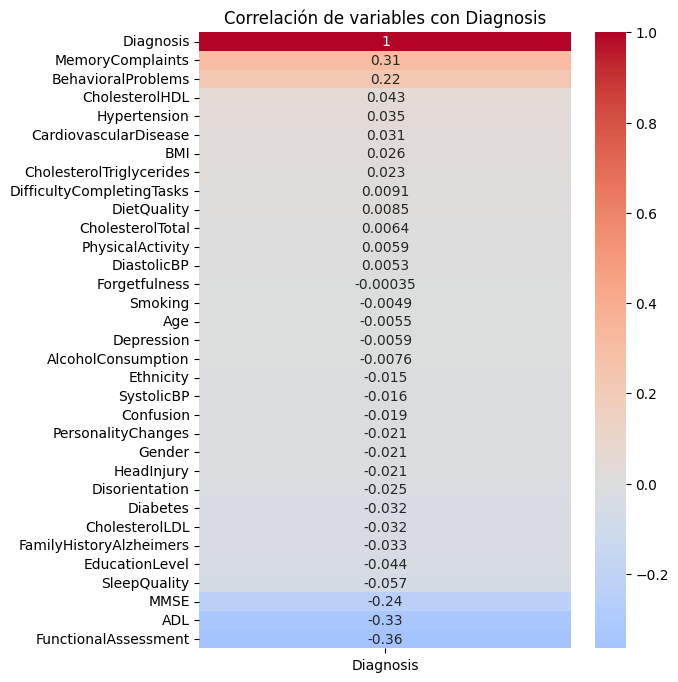

In [74]:
# Correlación entre variables numéricas y Diagnosis

corr_vars = datos.select_dtypes(include=["int64", "float64"]).drop(columns=["PatientID"], errors="ignore")

# Calcular correlación con Diagnosis
corr_with_target = corr_vars.corr()["Diagnosis"].sort_values(ascending=False)

print("\nCorrelación de cada variable con Diagnosis:")
print(corr_with_target)

# Graficar heatmap solo con las correlaciones respecto a Diagnosis
plt.figure(figsize=(6, 8))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlación de variables con Diagnosis")
plt.show()

Los resultados de correlación muestran que las variables más asociadas positivamente con el diagnóstico de Alzheimer son quejas de memoria (0.31) y problemas de comportamiento (0.22), lo que indica que estos síntomas suelen presentarse con mayor frecuencia en pacientes diagnosticados. En contraste, las correlaciones negativas más destacadas aparecen en variables relacionadas con la funcionalidad y el rendimiento cognitivo, como evaluación funcional (-0.36), actividades de la vida diaria (-0.33) y MMSE (-0.24), lo cual confirma que un peor desempeño en estas escalas está vinculado a un mayor riesgo de diagnóstico. La mayoría de las variables clínicas y de estilo de vida (como presión arterial, colesterol, consumo de alcohol o tabaquismo) muestran correlaciones muy bajas, lo que sugiere que en este conjunto de datos no tienen un papel predictivo relevante frente al diagnóstico de Alzheimer.

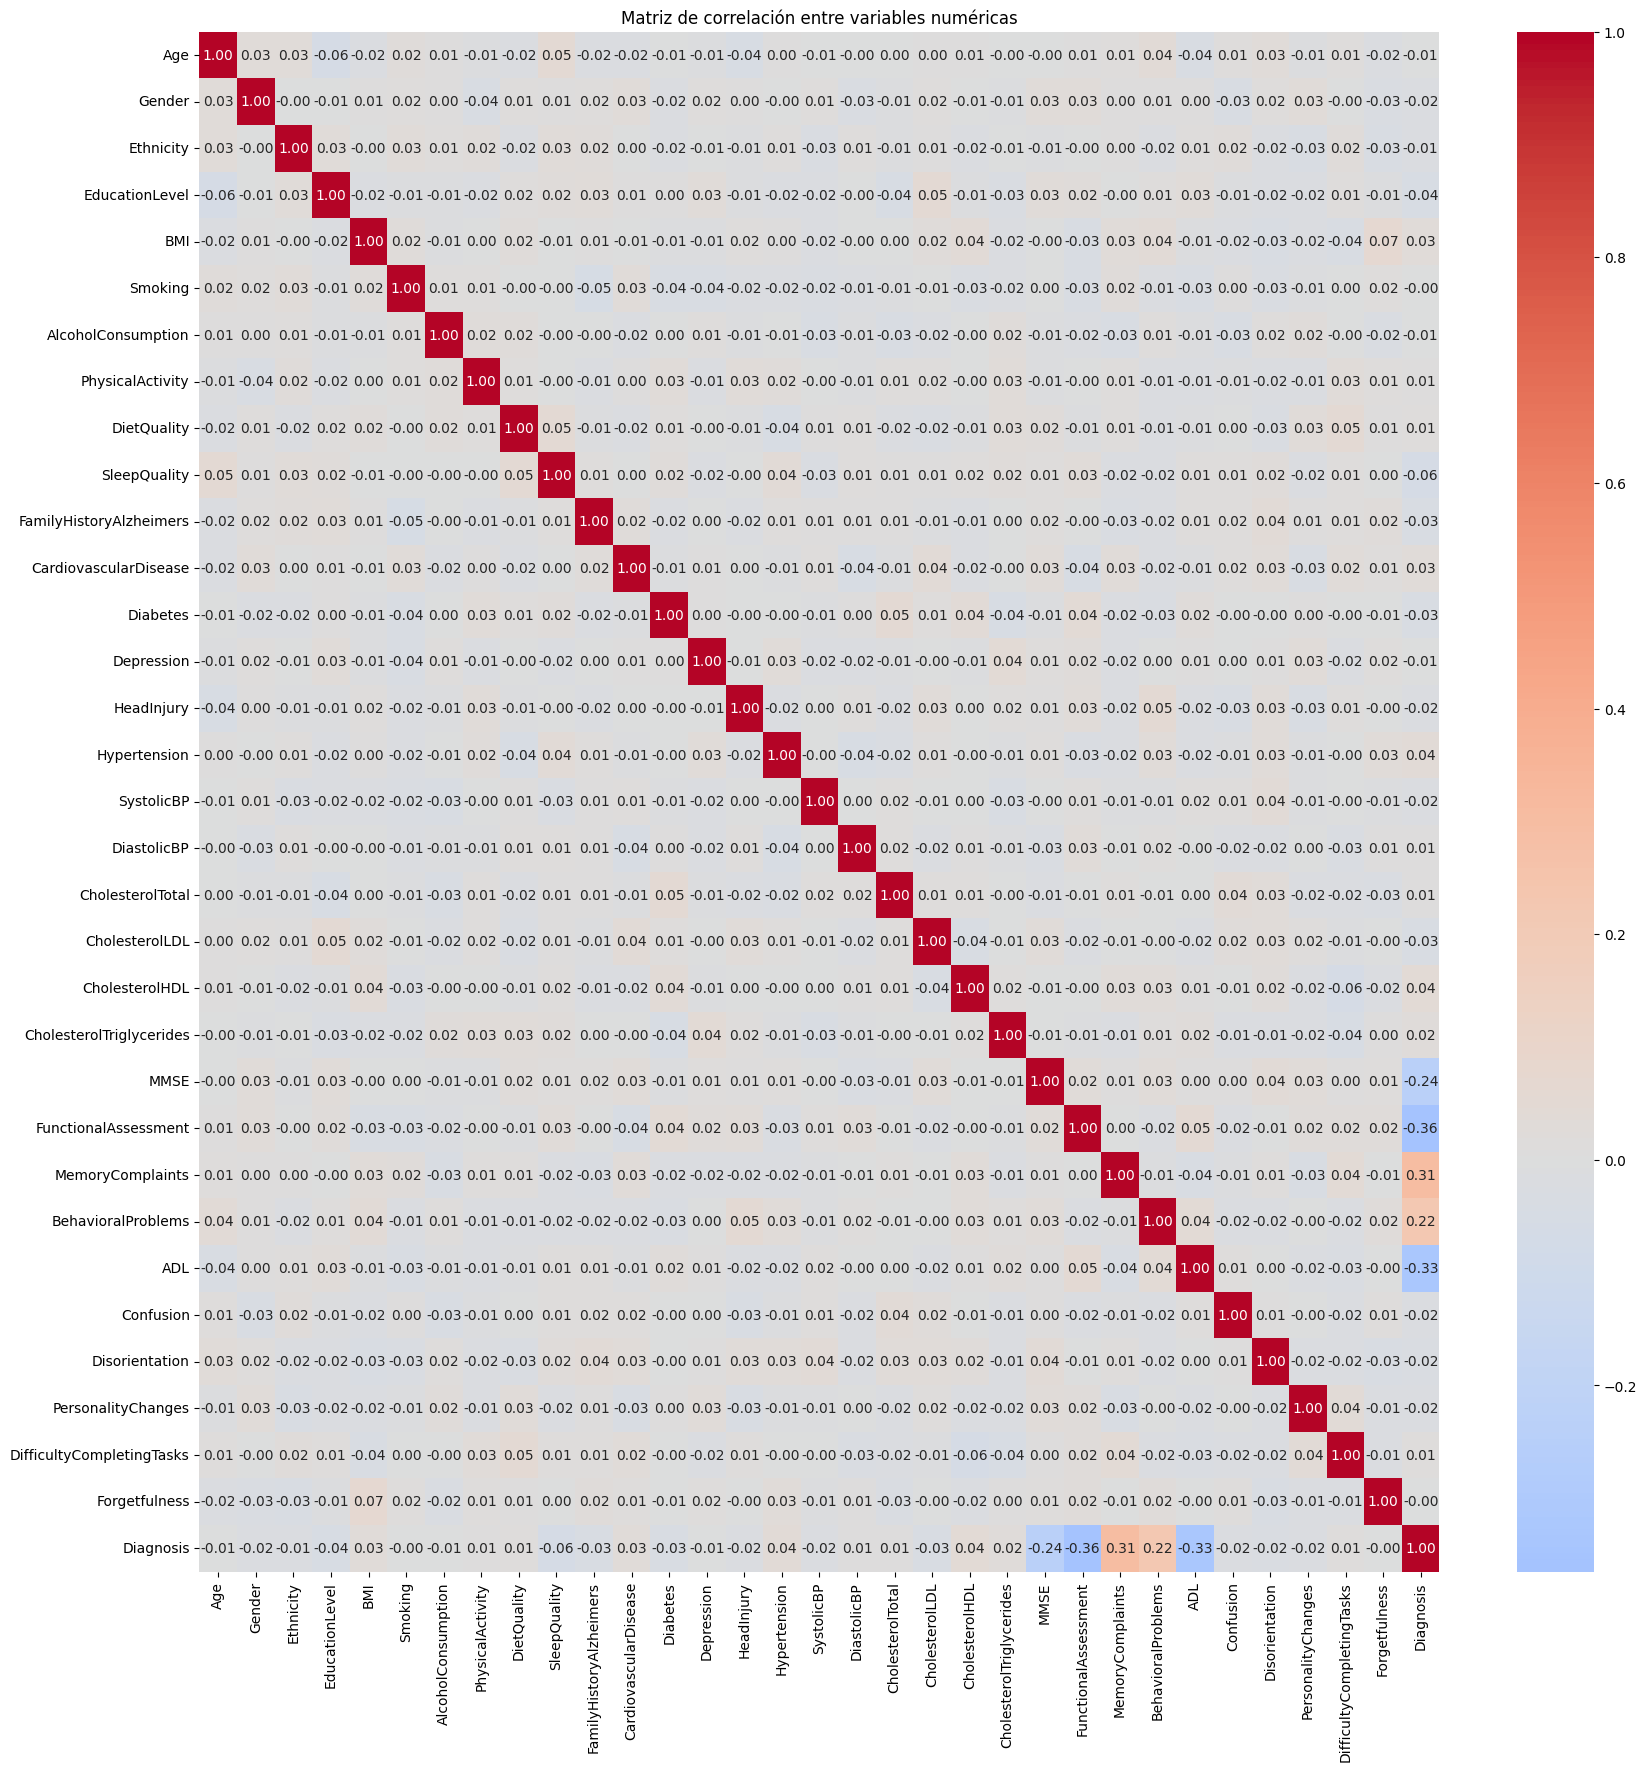

In [75]:
# Correlación entre variables numéricas (heatmap completo)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_vars.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

La matriz de correlación refleja que la mayoría de las variables numéricas presentan correlaciones muy bajas entre sí, lo que indica que aportan información relativamente independiente al problema de predicción. Sin embargo, se destacan algunas asociaciones relevantes: las variables MMSE, evaluación funcional (FunctionalAssessment) y actividades de la vida diaria (ADL) muestran correlaciones negativas moderadas con el diagnóstico, lo que confirma que un mayor deterioro cognitivo y funcional está relacionado con la presencia de Alzheimer. Por otro lado, variables como quejas de memoria y problemas de comportamiento presentan correlaciones positivas moderadas con el diagnóstico, reforzando su papel como síntomas clínicos clave. En general, el mapa sugiere que los factores más predictivos en este dataset no son tanto los biomarcadores clínicos (colesterol, presión arterial, IMC), sino los relacionados directamente con el desempeño cognitivo y los síntomas conductuales.

## 3. Procesamiento de datos

In [ ]:
# Manejo de valores faltantes
# Eliminemos las filas con datos faltantes:
datos.dropna(axis=0, how='any', inplace=True)

# Eliminar columnas irrelevantes (PatientID, DoctorInCharge)
datos.drop(columns=["PatientID", "DoctorInCharge"], inplace=True, errors="ignore")

# Verifiquemos que ya no haya datos faltantes en ninguna columna:
# datos.isna().sum()

# Separar variables predictoras (X) y target (y)
X = datos.drop(columns=["Diagnosis"])
y = datos["Diagnosis"]

num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Variables numéricas:", num_features)
print("Variables categóricas:", cat_features)

# Observamos que no hay variables categóricas en este dataset, por tanto no se incluye preprocesamiento para ellas.

# Dividir datos en entrenamiento, prueba y validación
# Primero 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Luego dividir temp en val (15%) y test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print(f"Tamaño de X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Tamaño de X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Tamaño de X_test: {X_test.shape}, y_test: {y_test.shape}")

#Índices de las columnas numéricas y categoricas de X_train
num_cols = X_train.select_dtypes(include=np.number).columns

# Creación de preprocesamiento con ColumnTransformer y Pipelines
# Para variables numéricas → escalar
num_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols)
    ]
)


Variables numéricas: ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']
Variables categóricas: []
Tamaño de X_train: (1504, 32), y_train: (1504,)
Tamaño de X_val: (322, 32), y_val: (322,)
Tamaño de X_test: (323, 32), y_test: (323,)
